In [1]:
import os 
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, "words.xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    img_paths, img_sizes, img_labels, bboxes = [], [], [], []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall("taggedRectangles"):
            for bb in bbs:
                if not bb[0].text.isalnum():
                    continue
                bbs_of_img.append([float(bb.attrib["x"]),
                                   float(bb.attrib["y"]),
                                   float(bb.attrib["width"]),
                                   float(bb.attrib["height"])])
                labels_of_img.append(bb[0].text.lower())
        
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

datset_dir = "SceneTrialTrain"
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(datset_dir)

In [3]:
bboxes[1]

[[432.0, 635.0, 847.0, 172.0]]

In [ ]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))
            #Eliminate if 90% of the cropped image is black and white
            if np.mean(cropped_img) < 25 or np.mean(cropped_img) > 220:
                continue
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            label = new_img_path + '\t' + label
            labels.append(label)
            count +=1
    
    print(f"Create {count} images")

    with open(os.path.join(save_dir, "labels.txt"), "w") as f:
        for label in labels:
            f.write(f"{label}\n")

save_dir = "ocr_dataset"
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Create 1093 images


In [5]:
root_dir = save_dir

image_paths, labels = [], []

with open(os.path.join(root_dir, "labels.txt"), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        image_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(image_paths)}")

Total images: 1093


In [6]:
labels

['self',
 'adhesive',
 'address',
 'labels',
 '36',
 '250',
 'on',
 'a',
 'roll',
 'natwest',
 'greek',
 'gastronomy',
 'cookery',
 'wines',
 'local',
 'toubrs',
 'specialties',
 'festive',
 'recipes',
 'illustrated',
 '83',
 '73',
 'the',
 'house',
 'of',
 'the',
 'spirits',
 'isabel',
 'allende',
 'intensely',
 'moving',
 'both',
 'entertaining',
 'and',
 'deeply',
 'serious',
 'evening',
 'standard',
 'digital',
 'multimedia',
 'wiley',
 'nigel',
 'chapman',
 'and',
 'jenny',
 'chapman',
 'software',
 'design',
 'for',
 'systems',
 'j',
 'e',
 'cooling',
 'nokia',
 'adapter',
 'cable',
 'dlr',
 '3p',
 'a4382',
 'nokia',
 '6210',
 'dlr',
 '3p',
 'data',
 'cable',
 'professional',
 'issues',
 'in',
 'software',
 'engineering',
 'frank',
 'bott',
 'allison',
 'coleman',
 'jack',
 'eaton',
 'diane',
 'rowland',
 'third',
 'edition',
 'silberschatz',
 'galvin',
 'operating',
 'system',
 'concepts',
 'fifth',
 'edition',
 'systems',
 'series',
 'systems',
 'analysis',
 'design',
 'stems',

In [7]:
letters = [char for char in labels]
letters

['self',
 'adhesive',
 'address',
 'labels',
 '36',
 '250',
 'on',
 'a',
 'roll',
 'natwest',
 'greek',
 'gastronomy',
 'cookery',
 'wines',
 'local',
 'toubrs',
 'specialties',
 'festive',
 'recipes',
 'illustrated',
 '83',
 '73',
 'the',
 'house',
 'of',
 'the',
 'spirits',
 'isabel',
 'allende',
 'intensely',
 'moving',
 'both',
 'entertaining',
 'and',
 'deeply',
 'serious',
 'evening',
 'standard',
 'digital',
 'multimedia',
 'wiley',
 'nigel',
 'chapman',
 'and',
 'jenny',
 'chapman',
 'software',
 'design',
 'for',
 'systems',
 'j',
 'e',
 'cooling',
 'nokia',
 'adapter',
 'cable',
 'dlr',
 '3p',
 'a4382',
 'nokia',
 '6210',
 'dlr',
 '3p',
 'data',
 'cable',
 'professional',
 'issues',
 'in',
 'software',
 'engineering',
 'frank',
 'bott',
 'allison',
 'coleman',
 'jack',
 'eaton',
 'diane',
 'rowland',
 'third',
 'edition',
 'silberschatz',
 'galvin',
 'operating',
 'system',
 'concepts',
 'fifth',
 'edition',
 'systems',
 'series',
 'systems',
 'analysis',
 'design',
 'stems',

In [8]:
letters = "".join(letters)
letters

'selfadhesiveaddresslabels36250onarollnatwestgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustrated8373thehouseofthespiritsisabelallendeintenselymovingbothentertaininganddeeplyseriouseveningstandarddigitalmultimediawileynigelchapmanandjennychapmansoftwaredesignforsystemsjecoolingnokiaadaptercabledlr3pa4382nokia6210dlr3pdatacableprofessionalissuesinsoftwareengineeringfrankbottallisoncolemanjackeatondianerowlandthirdeditionsilberschatzgalvinoperatingsystemconceptsfiftheditionsystemsseriessystemsanalysisdesignstemsidmasonlesliewillcocksbusinessstrategyitstrategyinformationwearsalanclementstrinciplesofomputerhardwaresecondeditionsoftwareengineeringiansommervillesonyconditionshandlewithcarepleaesreturntofuturepublishingltdsomertonta116tbunitedkingdomeditionsystemsdatabaseanintroductiontodatesixthstuartrussellpeternorvigintelligencertificialamodernapproachessenceofcomputingtheessenceofartificialintelligencestudentsengineeringforcommunicationociinternationalcomputerscience

In [9]:
letters = sorted(list(set(list(letters))))

In [10]:
len(letters)

38

In [11]:
chars = "".join(letters)

In [12]:
chars

'0123456789abcdefghijklmnopqrstuvwxyzéñ'

In [13]:
blank_char = '-'
chars += blank_char
chars

'0123456789abcdefghijklmnopqrstuvwxyzéñ-'

In [14]:
char_to_idx = {char: idx +1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [ ]:
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor([char_to_idx[char] for char in label], dtype=torch.int32)
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.int32)
    # same size of the tensor to avoid errors when using Dataloader module
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths

In [16]:
max_label_len

14

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char: # Ignore repeated characters: CTCloss
                        decoded_label.append(char)
                        prev_char = char
        decoded_sequences.append("".join(decoded_label))
    print(f"From {encoded_sequences} to {decoded_sequences}")
    return decoded_sequences

In [18]:
data_transform = {"train": transforms.Compose([
    transforms.Resize((100, 420)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=1, shear=1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
    transforms.RandomRotation(degrees=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]),
    "val": transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])}

In [19]:
val_size = 0.1
test_size = 0.1

X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=val_size + test_size, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_size / (val_size + test_size), shuffle=True)

In [ ]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len, transform=None, label_encoder=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)  
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(label, self.char_to_idx, self.max_label_len)
        return img, encoded_label, label_len

In [21]:
train_dataset = STRDataset(X_train, y_train, char_to_idx, max_label_len, data_transform["train"], encode)
val_dataset = STRDataset(X_val, y_val, char_to_idx, max_label_len, data_transform["val"], encode)
test_dataset = STRDataset(X_test, y_test, char_to_idx, max_label_len, data_transform["val"], encode)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
len(train_dataset), len(val_dataset), len(test_dataset)

(874, 109, 110)

In [ ]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2, unfreeze_layers=3):
        super().__init__()

        backbone = timm.create_model("resnet101", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2] # B*2048*H*W
        modules.append(nn.AdaptiveAvgPool2d((1, None))) # B*2048*1*W
        self.backbone = nn.Sequential(*modules)

        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True
        # nn.Linear applies to the last dim
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(dropout),
        )

        self.gru = nn.GRU(512, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        activation = self.backbone(x)
        activation = activation.permute(0, 3, 1, 2) # B*W*2048*1
        activation = activation.view(activation.size(0), activation.size(1), -1) # B*W*2048
        activation = self.mapSeq(activation)
        activation, _ = self.gru(activation)
        activation = self.layer_norm(activation)
        activation = self.out(activation)
        activation = activation.permute(1, 0, 2) # requirement of CTCloss

        return activation
    


In [24]:
vocab_size = len(chars)
vocab_size


39

In [25]:
hidden_size = 256
num_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(vocab_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_prob, unfreeze_layers=unfreeze_layers).to(device)


In [26]:
def evaluate(model, val_loader, loss_function, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(size=(outputs.size(1),), 
                                     fill_value = outputs.size(0),
                                     dtype=torch.long).to(device)
            loss = loss_function(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())
            loss = sum(losses) / len(losses)
    return loss

def train(model, train_loader, val_loader, loss_function, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []
        model.train()

        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits_lens = torch.full(size=(outputs.size(1),), 
                                     fill_value = outputs.size(0),
                                     dtype=torch.long).to(device)
            loss = loss_function(outputs, labels, logits_lens, labels_len)

            if torch.isnan(loss):
                print(f"NaN detected at epoch {epoch+1}, batch {idx+1}! Stopping training.")
                return train_losses, val_losses
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())
        
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, loss_function, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch +1} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f} | time: {time.time() - start:.2f}s"
        )
        scheduler.step()

    return train_losses, val_losses

In [27]:
epochs = 65
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

loss_function = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean"
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)



In [28]:
train_losses, val_losses = train(model, train_loader, val_loader, loss_function, optimizer, scheduler, device, epochs)

EPOCH 1 | train loss: 4.0696 | val loss: 3.4609 | time: 4.55s
EPOCH 2 | train loss: 3.5285 | val loss: 3.2783 | time: 3.59s
EPOCH 3 | train loss: 3.3232 | val loss: 3.1979 | time: 3.55s
EPOCH 4 | train loss: 3.1083 | val loss: 2.8522 | time: 3.54s
EPOCH 5 | train loss: 2.8408 | val loss: 2.5385 | time: 3.49s
EPOCH 6 | train loss: 2.3676 | val loss: 2.1640 | time: 3.47s
EPOCH 7 | train loss: 1.9541 | val loss: 1.7294 | time: 3.50s
EPOCH 8 | train loss: 1.5252 | val loss: 1.4351 | time: 3.54s
EPOCH 9 | train loss: 1.1943 | val loss: 1.0553 | time: 3.37s
EPOCH 10 | train loss: 0.9531 | val loss: 1.0015 | time: 3.51s
EPOCH 11 | train loss: 0.8290 | val loss: 1.0696 | time: 3.54s
EPOCH 12 | train loss: 0.6516 | val loss: 1.0305 | time: 3.60s
EPOCH 13 | train loss: 0.5930 | val loss: 0.9690 | time: 3.42s
EPOCH 14 | train loss: 0.5109 | val loss: 0.9089 | time: 3.51s
EPOCH 15 | train loss: 0.4238 | val loss: 0.8328 | time: 3.38s
EPOCH 16 | train loss: 0.3712 | val loss: 0.7786 | time: 3.42s
E

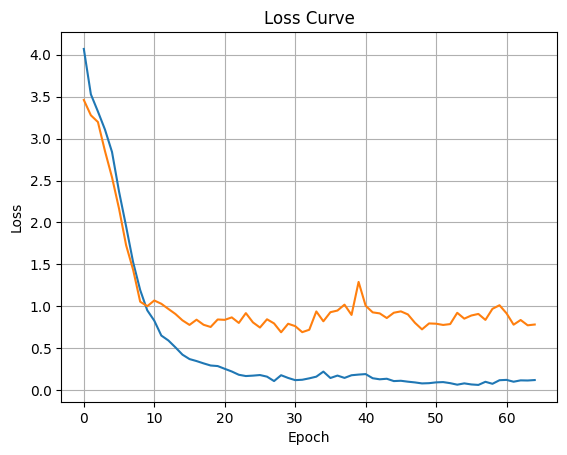

In [31]:

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()

In [32]:
val_loss = evaluate(model, val_loader, loss_function, device)
test_loss = evaluate(model, test_loader, loss_function, device)
print(val_loss, test_loss)

0.7832137942314148 1.0691222995519638


In [33]:
save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)